# Analyzing ADCP Data with MHKiT

The following example illustrates a straightforward workflow for analyzing Acoustic Doppler Current Profiler (ADCP) data utilizing MHKiT. MHKiT has integrated the DOLfYN codebase as a module to facilitate ADCP and Acoustic Doppler Velocimetry (ADV) data processing.

Here is a standard workflow for ADCP data analysis:

1. **Import Data**

2. **Review, QC, and Prepare the Raw Data**:
   1. Calculate or verify the correctness of depth bin locations
   2. Discard data recorded above the water surface or below the seafloor
   3. Assess the quality of velocity, beam amplitude, and/or beam correlation data
   4. Rotate Data Coordinate System

3. **Data Averaging**: 
    - If not already executed within the instrument, average the data into time bins of a predetermined duration, typically between 5 and 10 minutes

4. **Speed and Direction**

5. **Plotting**

6. **Saving and Loading DOLfYN datasets**

7. **Turbulence Statistics**
    1. Turbulence Intensity (TI)
    2. Power Spectral Densities
    3. Instrument Noise
    4. TKE Dissipation Rate
    5. Noise-corrected TI
    6. TKE Componenets
    7. TKE Production
    8. TKE Balance 


Begin your analysis by importing the requisite tools:

In [1]:
from mhkit import dolfyn
from mhkit.dolfyn.adp import api

c:\Users\mcve343\anaconda3\envs\tsdat-pipelines\lib\site-packages\xarray\backends\cfgrib_.py:29: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


##  1. Importing Raw Instrument Data

One of DOLfYN's key features is its ability to directly import raw data from an Acoustic Doppler Current Profiler (ADCP) right after it has been transferred. In this instance, we are using a Nortek Signature1000 ADCP, with the data stored in files with an '.ad2cp' extension. This specific dataset represents several hours of velocity data, captured at 1 Hz by an ADCP mounted on a bottom lander within a tidal inlet. The list of instruments compatible with DOLfYN can be found in the [MHKiT DOLfYN documentation](https://mhkit-software.github.io/MHKiT/mhkit-python/api.dolfyn.html).

We'll start by importing the raw data file downloaded from the instrument. The `read` function processes the raw file and converts the information into an xarray Dataset. This Dataset includes several groups of variables:

1. **Velocity**: Recorded in the coordinate system saved by the instrument (beam, XYZ, ENU)
2. **Beam Data**: Includes amplitude and correlation data
3. **Instrumental & Environmental Measurements**: Captures the instrument's bearing and environmental conditions
4. **Orientation Matrices**: Used by DOLfYN for rotating through different coordinate frames.


In [2]:
ds = dolfyn.read("data/dolfyn/Sig1000_tidal.ad2cp")

Reading file data/dolfyn/Sig1000_tidal.ad2cp ...


There are two ways to see what's in a Dataset. The first is to simply type the dataset's name to see the standard xarray output. To access a particular variable in a dataset, use dict-style (`ds['vel']`) or attribute-style syntax (`ds.vel`). See the [xarray docs](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html) for more details on how to use the xarray format.

In [3]:
# print the dataset
ds

<xarray.Dataset>
Dimensions:              (time: 55000, dirIMU: 3, dir: 4, range: 28, beam: 4,
                          earth: 3, inst: 3, q: 4, time_b5: 55000,
                          range_b5: 28, x1: 4, x2: 4)
Coordinates:
  * time                 (time) datetime64[ns] 2020-08-15T00:20:00.500999927 ...
  * dirIMU               (dirIMU) <U1 'E' 'N' 'U'
  * dir                  (dir) <U2 'E' 'N' 'U1' 'U2'
  * range                (range) float64 0.6 1.1 1.6 2.1 ... 12.6 13.1 13.6 14.1
  * beam                 (beam) int32 1 2 3 4
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
  * q                    (q) <U1 'w' 'x' 'y' 'z'
  * time_b5              (time_b5) datetime64[ns] 2020-08-15T00:20:00.4384999...
  * range_b5             (range_b5) float64 0.6 1.1 1.6 2.1 ... 13.1 13.6 14.1
  * x1                   (x1) int32 1 2 3 4
  * x2                   (x2) int32 1 2 3 4
Data variables: (12/38)
    c_sound              (time) float32 1.502e+03 1.502e+03 ... 1.498e+03
    temp                 (time) float32 14.55 14.55 14.55 ... 13.47 13.47 13.47
    pressure             (time) float32 9.713 9.718 9.718 ... 9.596 9.594 9.596
    mag                  (dirIMU, time) float32 72.5 72.7 72.6 ... -197.2 -195.7
    accel                (dirIMU, time) float32 -0.00479 -0.01437 ... 9.729
    batt                 (time) float32 16.6 16.6 16.6 16.6 ... 16.4 16.4 15.2
    ...                   ...
    telemetry_data       (time) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    boost_running        (time) uint8 0 0 0 0 0 0 0 0 1 0 ... 0 1 0 0 0 0 0 0 1
    heading              (time) float32 -12.52 -12.51 -12.51 ... -12.52 -12.5
    pitch                (time) float32 -0.065 -0.06 -0.06 ... -0.06 -0.05 -0.05
    roll                 (time) float32 -7.425 -7.42 -7.42 ... -6.45 -6.45 -6.45
    beam2inst_orientmat  (x1, x2) float32 1.183 0.0 -1.183 ... 0.5518 0.0 0.5518
Attributes: (12/34)
    filehead_config:       {"CLOCKSTR": {"TIME": "\"2020-08-13 13:56:21\""}, ...
    inst_model:            Signature1000
    inst_make:             Nortek
    inst_type:             ADCP
    burst_config:          {"press_valid": true, "temp_valid": true, "compass...
    n_cells:               28
    ...                    ...
    proc_idle_less_12pct:  0
    rotate_vars:           ['vel', 'accel', 'accel_b5', 'angrt', 'angrt_b5', ...
    coord_sys:             earth
    fs:                    1
    has_imu:               1
    beam_angle:            25

A second way provided to look at data is through the *DOLfYN view*. This view has several convenience methods, shortcuts, and functions built-in. It includes an alternate – and somewhat more informative/compact – description of the data object when in interactive mode. This can be accessed using

In [4]:
ds_dolfyn = ds.velds
ds_dolfyn

<ADCP data object>:  Nortek Signature1000
  . 15.28 hours (started: Aug 15, 2020 00:20)
  . earth-frame
  . (55000 pings @ 1Hz)
  Variables:
  - time ('time',)
  - time_b5 ('time_b5',)
  - vel ('dir', 'range', 'time')
  - vel_b5 ('range_b5', 'time_b5')
  - range ('range',)
  - orientmat ('earth', 'inst', 'time')
  - heading ('time',)
  - pitch ('time',)
  - roll ('time',)
  - temp ('time',)
  - pressure ('time',)
  - amp ('beam', 'range', 'time')
  - amp_b5 ('range_b5', 'time_b5')
  - corr ('beam', 'range', 'time')
  - corr_b5 ('range_b5', 'time_b5')
  - accel ('dirIMU', 'time')
  - angrt ('dirIMU', 'time')
  - mag ('dirIMU', 'time')
  ... and others (see `<obj>.variables`)

## 2. Initial Steps for Data Quality Control (QC)

### 2.1: Set the Deployment Height

When using Nortek instruments, the deployment software does not factor in the deployment height. The deployment height represents the position of the Acoustic Doppler Current Profiler (ADCP) within the water column. 

In this context, the center of the first depth bin is situated at a distance that is the sum of three elements: 
1. Deployment height (the ADCP's position in the water column)
2. Blanking distance (the minimum distance from the ADCP to the first measurement point)
3. Cell size (the vertical distance of each measurement bin in the water column)

To ensure accurate readings, it is critical to calibrate the 'range' coordinate to make '0' correspond to the seafloor. This calibration can be achieved using the `set_range_offset` function. This function is also useful when working with a down-facing instrument as it helps account for the depth below the water surface. 

For those using a Teledyne RDI ADCP, the TRDI deployment software will prompt you to specify the deployment height/depth during setup. If there's a need for calibration post-deployment, the `set_range_offset` function can be utilized in the same way as described above.

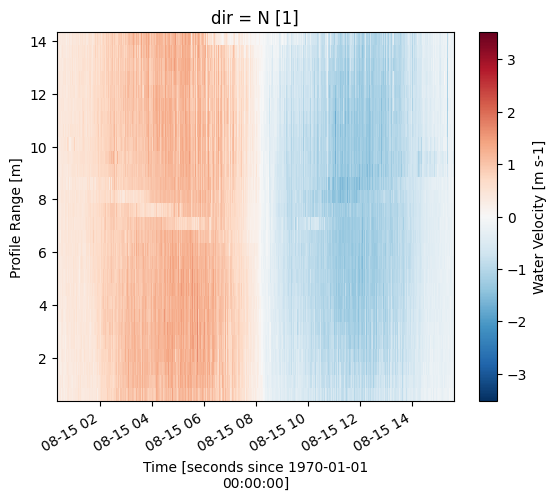

In [5]:
ds["vel"][1].plot()

In [6]:
# The ADCP transducers were measured to be 0.6 m from the feet of the lander
api.clean.set_range_offset(ds, 0.6)

So, the center of bin 1 is located at 1.2 m:

In [7]:
ds.range

<xarray.DataArray 'range' (range: 28)>
array([ 1.2,  1.7,  2.2,  2.7,  3.2,  3.7,  4.2,  4.7,  5.2,  5.7,  6.2,  6.7,
        7.2,  7.7,  8.2,  8.7,  9.2,  9.7, 10.2, 10.7, 11.2, 11.7, 12.2, 12.7,
       13.2, 13.7, 14.2, 14.7])
Coordinates:
  * range    (range) float64 1.2 1.7 2.2 2.7 3.2 ... 12.7 13.2 13.7 14.2 14.7
Attributes:
    units:    m

### 2.2. Discard Data Above Surface Level

To reduce computational load, we can exclude all data at or above the water surface level. Since the instrument was oriented upwards, we can utilize the pressure sensor data along with the function `find_surface_from_P`. However, this approach necessitates that the pressure sensor was calibrated or 'zeroed' prior to deployment. If the instrument is facing downwards or doesn't include pressure data, the function `find_surface` can be used to detect the seabed or water surface.

It's important to note that Acoustic Doppler Current Profilers (ADCPs) do not measure water salinity, so you'll need to supply this information to the function. The dataset returned by this function includes an additional variable, "depth". If `find_surface_from_P` is invoked after `set_range_offset`, "depth" represents the distance from the water surface to the seafloor. Otherwise, it indicates the distance to the ADCP pressure sensor.

After determining the "depth", you can use the nan_beyond_surface function to discard data in depth bins at or above the actual water surface. Be aware that this function will generate a new dataset.

In [8]:
api.clean.find_surface_from_P(ds, salinity=31)
ds = api.clean.nan_beyond_surface(ds)

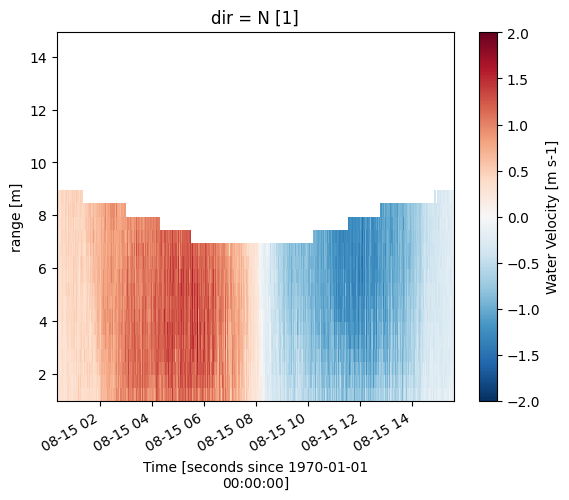

In [9]:
ds["vel"][1].plot()

### 2.3: Apply an Acoustic Signal Correlation Filter

After removing data from bins at or above the water surface, we typically apply a filter based on acoustic signal correlation to the ADCP data. This helps to eliminate erroneous velocity data points, which can be caused by factors such as bubbles, kelp, fish, etc., moving through one or multiple beams.

You can quickly inspect the data to determine an appropriate correlation value by using the built-in plotting feature of xarray. In the following example, we use xarray's slicing capabilities to display data from beam 1 within a range of 0 to 10 m from the ADCP.

It's important to note that not all ADCPs provide acoustic signal correlation data, which serves as a quantitative measure of signal quality. Older ADCPs may not offer this feature, in which case you can skip this step when using such instruments.

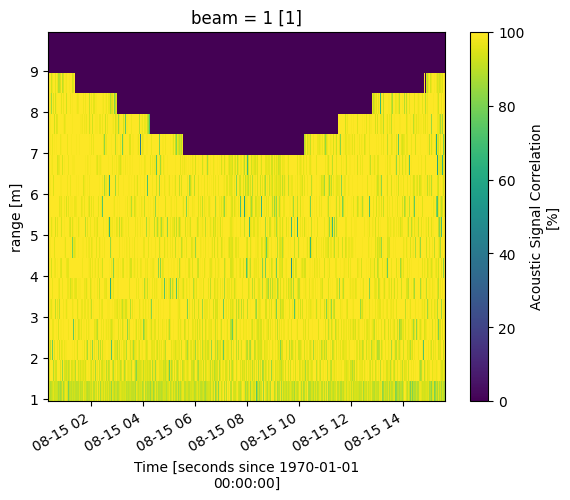

In [10]:
%matplotlib inline
ds["corr"].sel(beam=1, range=slice(0, 10)).plot()

It's beneficial to also review data from the other beams. A significant portion of this data is of high quality. To avoid discarding valuable data with lower correlations, which could be due to natural variations, we can use the `correlation_filter`. This function assigns a value of NaN (not a number) to velocity values corresponding to correlations below 50%.

However, it's important to note that the correlation threshold is dependent on the specifics of the deployment environment and the instrument used. It's not unusual to set a threshold as low as 30%, or even to forgo the use of this function entirely.

In [11]:
ds = api.clean.correlation_filter(ds, thresh=50)

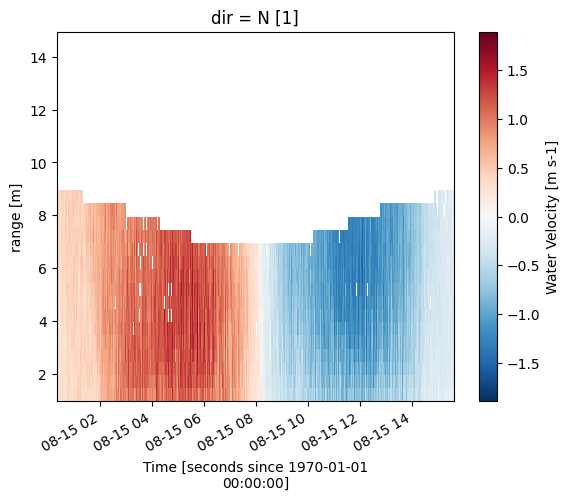

In [12]:
ds["vel"][1].plot()

### 2.4 Rotate Data Coordinate System

After cleaning the data, the next step is to rotate the velocity data into accurate East, North, Up (ENU) coordinates.

ADCPs utilize an internal compass or magnetometer to determine magnetic ENU directions. You can use the set_declination function to adjust the velocity data according to the magnetic declination specific to your geographical coordinates. This declination can be looked up online for specific coordinates.

Instruments save vector data in the coordinate system defined in the deployment configuration file. To make this data meaningful, it must be transformed through various coordinate systems ("beam"<->"inst"<->"earth"<->"principal"). This transformation is accomplished using the `rotate2` function. If the "earth" (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset through the required coordinate systems to reach the "earth" coordinates. Setting `inplace` to true will modify the input dataset directly, meaning it will not create a new dataset.

In this case, since the ADCP data is already in the "earth" coordinate system, the `rotate2` function will return the input dataset without modifications. The `set_declination` function will work no matter the coordinate system.

In [13]:
dolfyn.set_declination(ds, 15.8, inplace=True)  # 15.8 deg East
dolfyn.rotate2(ds, "earth", inplace=True)

Data is already in the earth coordinate system


To rotate into the principal frame of reference (streamwise, cross-stream, vertical), if desired, we must first calculate the depth-averaged principal flow heading and add it to the dataset attributes. Then the dataset can be rotated using the same `rotate2` function. We use `inplace=False` because we do not want to alter the input dataset here.

In [14]:
ds.attrs["principal_heading"] = dolfyn.calc_principal_heading(ds["vel"].mean("range"))
ds_streamwise = dolfyn.rotate2(ds, "principal", inplace=False)

## 3. Average the Data

As this deployment was configured in "burst mode", a standard step in the analysis process is to average the velocity data into time bins. 

However, if the instrument was set up in an "averaging mode" (where a specific profile and/or average interval was set, for instance, averaging 5 minutes of data every 30 minutes), this step would have been performed within the ADCP during deployment and can thus be skipped.

To average the data into time bins (also known as ensembles), you should first initialize the binning tool `ADPBinner`. The parameter "n_bin" represents the number of data points in each ensemble. In this case, we're dealing with 300 seconds' worth of data. The "fs" parameter stands for the sampling frequency, which for this deployment is 1 Hz. Once the binning tool is initialized, you can use the `bin_average` function to average the data into ensembles.

In [15]:
avg_tool = api.ADPBinner(n_bin=ds.fs * 300, fs=ds.fs)
ds_avg = avg_tool.bin_average(ds)

In [16]:
ds_avg

<xarray.Dataset>
Dimensions:         (time: 183, dirIMU: 3, range: 28, dir: 4, beam: 4,
                     earth: 3, inst: 3, q: 4, time_b5: 183, range_b5: 28)
Coordinates:
  * time            (time) datetime64[ns] 2020-08-15T00:22:30.001030683 ... 2...
  * dirIMU          (dirIMU) <U1 'E' 'N' 'U'
  * range           (range) float64 1.2 1.7 2.2 2.7 3.2 ... 13.2 13.7 14.2 14.7
  * dir             (dir) <U2 'E' 'N' 'U1' 'U2'
  * beam            (beam) int32 1 2 3 4
  * earth           (earth) <U1 'E' 'N' 'U'
  * inst            (inst) <U1 'X' 'Y' 'Z'
  * q               (q) <U1 'w' 'x' 'y' 'z'
  * time_b5         (time_b5) datetime64[ns] 2020-08-15T00:22:29.938495159 .....
  * range_b5        (range_b5) float64 1.2 1.7 2.2 2.7 ... 13.2 13.7 14.2 14.7
Data variables: (12/38)
    c_sound         (time) float32 1.502e+03 1.502e+03 ... 1.499e+03 1.498e+03
    U_std           (range, time) float32 0.04232 0.04293 0.04402 ... nan nan
    temp            (time) float32 14.49 14.59 14.54 14.45 ... 13.62 13.56 13.5
    pressure        (time) float32 9.712 9.699 9.685 9.67 ... 9.58 9.584 9.591
    mag             (dirIMU, time) float32 72.37 72.4 72.38 ... -197.1 -197.1
    accel           (dirIMU, time) float32 -0.3584 -0.361 ... 9.714 9.712
    ...              ...
    boost_running   (time) float32 0.1267 0.1333 0.13 ... 0.2267 0.22 0.22
    heading         (time) float32 3.287 3.261 3.337 3.289 ... 3.331 3.352 3.352
    pitch           (time) float32 -0.05523 -0.07217 ... -0.04288 -0.0429
    roll            (time) float32 -7.414 -7.424 -7.404 ... -6.446 -6.433 -6.436
    water_density   (time) float32 1.023e+03 1.023e+03 ... 1.023e+03 1.023e+03
    depth           (time) float32 10.28 10.26 10.25 10.23 ... 10.14 10.15 10.15
Attributes: (12/41)
    fs:                        1
    n_bin:                     300
    n_fft:                     300
    description:               Binned averages calculated from ensembles of s...
    filehead_config:           {"CLOCKSTR": {"TIME": "\"2020-08-13 13:56:21\"...
    inst_model:                Signature1000
    ...                        ...
    has_imu:                   1
    beam_angle:                25
    h_deploy:                  0.6
    declination:               15.8
    declination_in_orientmat:  1
    principal_heading:         11.1898

## 4. Calculate Speed and Direction

Two additional variables that might be of interest, which are not automatically provided, are the magnitude of the horizontal velocity (referred to as `U_mag` or speed) and its direction (`U_dir`). These can be accessed via "shortcut" functions through the keyword `velds`, as demonstrated in the subsequent code block.

For a comprehensive list of these "shortcut" functions, you can refer to the [DOLfYN documentation](https://dolfyn.readthedocs.io/en/latest/apidoc/dolfyn.shortcuts.html).

In [17]:
ds_avg["U_mag"] = ds_avg.velds.U_mag
ds_avg["U_dir"] = ds_avg.velds.U_dir

## Plotting

Plotting can be accomplished through the user's preferred package. Matplotlib is shown here for simplicity, and flow speed and direction are plotted below with a blue line delineating the water surface level.

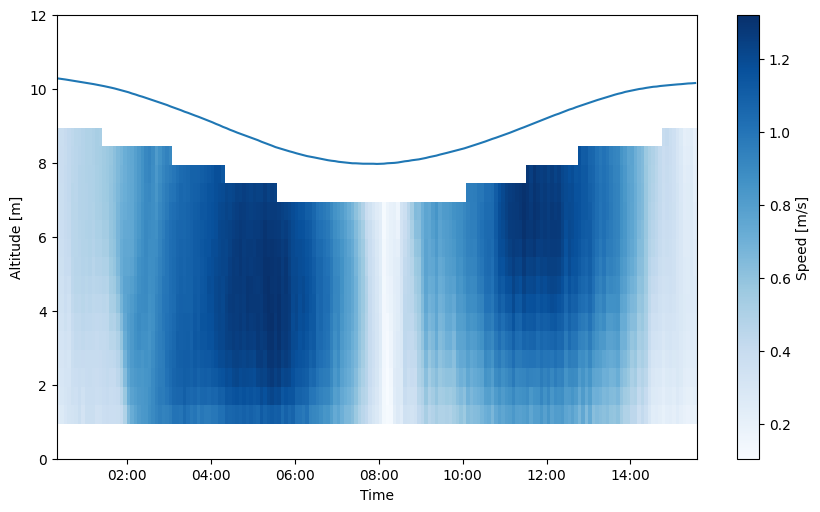

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as dt

ax = plt.figure(figsize=(10, 6)).add_axes([0.14, 0.14, 0.8, 0.74])
# Plot flow speed
t = dolfyn.time.dt642date(ds_avg["time"])
plt.pcolormesh(t, ds_avg["range"], ds_avg["U_mag"], cmap="Blues", shading="nearest")
# Plot the water surface
ax.plot(t, ds_avg["depth"])

# Set up time on x-axis
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(dt.DateFormatter("%H:%M"))

ax.set_ylabel("Altitude [m]")
ax.set_ylim([0, 12])
plt.colorbar(label="Speed [m/s]")

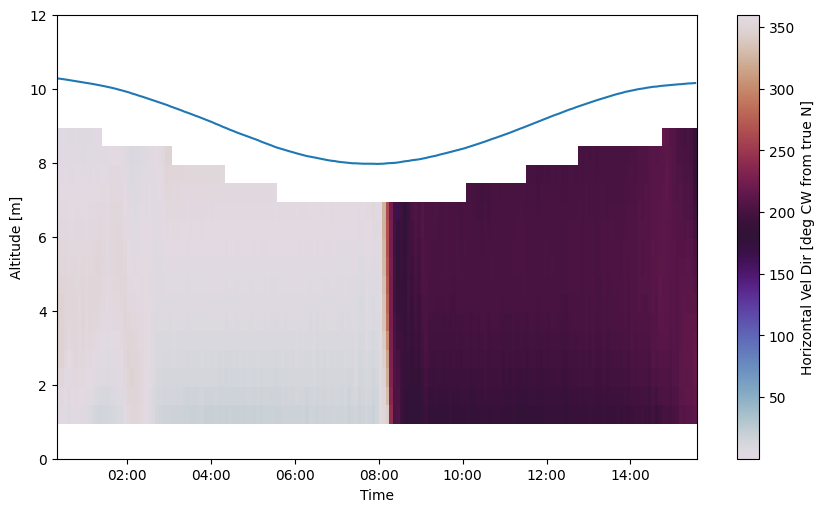

In [19]:
ax = plt.figure(figsize=(10, 6)).add_axes([0.14, 0.14, 0.8, 0.74])
# Plot flow direction
plt.pcolormesh(t, ds_avg["range"], ds_avg["U_dir"], cmap="twilight", shading="nearest")
# Plot the water surface
ax.plot(t, ds_avg["depth"])

# set up time on x-axis
ax.set_xlabel("Time")
ax.xaxis.set_major_formatter(dt.DateFormatter("%H:%M"))

ax.set_ylabel("Altitude [m]")
ax.set_ylim([0, 12])
plt.colorbar(label="Horizontal Vel Dir [deg CW from true N]");

## Saving and Loading DOLfYN datasets
Datasets can be saved and reloaded using the `save` and `load` functions. Xarray is saved natively in netCDF format, hence the ".nc" extension.

Note: DOLfYN datasets cannot be saved using xarray's native `ds.to_netcdf`; however, DOLfYN datasets can be opened using `xarray.open_dataset`.

In [20]:
# Uncomment these lines to save and load to your current working directory
# dolfyn.save(ds, 'your_data.nc')
# ds_saved = dolfyn.load('your_data.nc')

## 7. Turbulence Statistics

The next section of this jupyter notebook will run through the turbulence analysis of the data presented here. There was no intention of measuring turbulence in the deployment that collected this data, so results depicted here are not the highest quality. The quality of turbulence measurements from an ADCP depend heavily on the quality of the deployment setup and data collection, particularly instrument frequency, samping frequency and depth bin size.

Read more on proper ADCP setup for turbulence measurements in: Thomson, Jim, et al. "Measurements of turbulence at two tidal energy sites in Puget Sound, WA." IEEE Journal of Oceanic Engineering 37.3 (2012): 363-374.

Most functions related to turbulence statistics in MHKiT-DOLfYN have the papers they originate from referenced in their docstrings.

### 7.1 Turbulence Intensity
For most users, turbulence intensity (TI), the ratio of the ensemble standard deviation to ensemble flow speed given as a percent, is all most will need. In MHKiT, this can be simply calculated as `<raw dataset>.velds.I`, but be aware that this will be a conservative estimate. Another function, `turbulence_intensity`, is capable of subtracting instrument noise from this parameter and is discussed below. The noise-subtracted TI is more accurate and typically 1-2% lower than the non-noise-subtracted estimation.



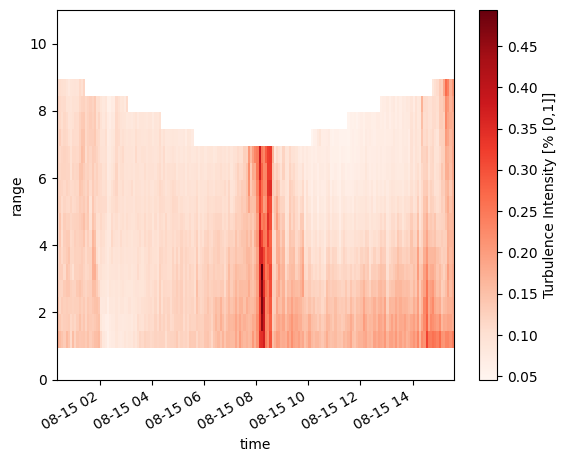

In [21]:
# Turbulence Intensity
ds_avg["TI"] = ds_avg.velds.I
ds_avg["TI"].plot(cmap="Reds", ylim=(0, 11))

### 7.2 Power Spectral Densities (Auto-Spectra)

Other turbulence parameters include the TKE power- and cross-spectral densities (i.e the power spectra), turbulent kinetic energy (TKE, i.e. the variances of velocity vector components), Reynolds stress vector (i.e. the co-variances of velocity vector components), TKE dissipation rate, and TKE production rate. These quantities are primarily used to inform and verify hydrodynamic and coastal models, which take some or all of these quantities as input.

The TKE production rate is the rate at which kinetic energy (KE) transitions from a useful state (able to do "work" in the physics sense) to turbulent; TKE is the actual amount of turbulent KE in the water; and TKE dissipation rate is the rate at which turbulent KE is lost to non-motion forms of energy (heat, sound, etc) due to viscosity. The power spectra are used to depict and quantify this energy in the frequency domain, and creating them are the first step in turbulence analysis.

We'll start by looking at the power spectra, specifically the auto-spectra from the vertical beam ("auto" meaning the variance of a single vector direction, e.g. $\overline{u'^2}$, vs "cross", meaning the covariance of two directions, e.g. $\overline{u'w'}$). This can be done using the `power_spectral_density` function from the `ADPBinner` we created ("avg_tool"). We'll create spectra at the middle water column, at a depth of 5 m, and use a number of FFT's equal to 1/3 the bin size.

In [22]:
rng = 5  # m
vel_up = ds["vel_b5"].sel(range_b5=rng, method="nearest")  # vertical velocity
U = ds_avg["U_mag"].sel(
    range=5, method="nearest"
)  # flow speed, for plotting in the next block

ds_avg["auto_spectra_5m"] = avg_tool.power_spectral_density(
    vel_up, freq_units="Hz", n_fft=ds_avg.n_bin // 3
)

In the auto-spectra, we're primarly looking for three components: the energy-producing region, the isotropic turbulence region (so-called "red noise"), and the instrument noise floor (termed "white noise"). 

The block below organizes and plots the power spectra by the corresponding ensemble speed, averaging them by 0.1 m/s velocity bins. Note that if an ensemble is missing data that wasn't filled in, a power spectrum will not be calculated for that ensemble timestamp.

[Text(0.5, 0, 'Frequency [Hz]'),
 Text(0, 0.5, 'PSD [m2 s-2 Hz-1]'),
 (0.01, 1),
 (0.0005, 0.1)]

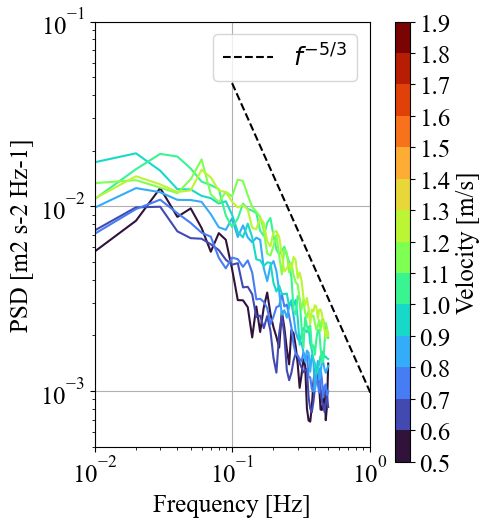

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams.update({"font.size": 18, "font.family": "Times New Roman"})


def plot_spectra_by_color(auto_spectra, U_mag, ax, fig, cbar_max=4.0):
    U = U_mag.values
    U_max = U_mag.max().values

    # Average spectra into 0.1 m/s velocity bins
    speed_bins = np.arange(0.5, U_max, 0.1)
    time = [t for t in auto_spectra.dims if "time" in t][0]
    S_group = auto_spectra.assign_coords({time: U}).rename({time: "speed"})
    group = S_group.groupby_bins("speed", speed_bins)
    count = group.count().values
    S = group.mean()

    # define the colormap
    cmap = plt.cm.turbo
    # define the bins and normalize
    bounds = np.arange(0.5, cbar_max, 0.1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    colors = cmap(norm(speed_bins))

    # plot
    for i in range(len(speed_bins) - 1):
        ax.loglog(auto_spectra["freq"], S[i], c=colors[i])
    ax.grid()

    # create a second axes for the colorbar
    cax = fig.add_axes([0.8, 0.07, 0.03, 0.88])
    # cax, _ = mpl.colorbar.make_axes(fig.gca())
    sm = mpl.colorbar.ColorbarBase(
        cax,
        cmap=cmap,
        norm=norm,
        spacing="proportional",
        ticks=bounds,
        boundaries=bounds,
        format="%1.1f",
        label="Velocity [m/s]",
    )

    # Add -5/3 slope line
    m = -5 / 3
    x = np.logspace(-1, 0.5)
    y = 10 ** (-3) * x**m
    ax.loglog(x, y, "--", c="black", label="$f^{-5/3}$")
    ax.legend()

    return ax, sm


# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(left=0.2, right=0.75, top=0.95, bottom=0.1)

# Plot spectra by color
plot_spectra_by_color(ds_avg["auto_spectra_5m"], U, ax, fig, cbar_max=2.0)
# Set axes
ax.set(
    xlabel="Frequency [Hz]",
    ylabel="PSD [m2 s-2 Hz-1]",
    xlim=(0.01, 1),
    ylim=(0.0005, 0.1),
)

In the figure above, we can see the energy-producing turbulent structures below a frequency of 0.2 Hz (one tick to the right of "10^-1"). The isotropic turbulence cascade, seen by the dashed f^(-5/3) slope (from Kolmogorov's theory of turbulence) begins at around 0.2 Hz and continues until we reach the Nyquist frequency at 0.5 Hz (1/2 the instrument's sampling frequency, 1 Hz). The instrument's noise floor can't be seen here, but will show up as the flattened part of the spectra at the highest frequencies. For this instrument (Nortek Signature1000), the noise floor typically varies around 10^-3, depending on flow speed and range distance.

### 7.3 Instrument Noise

The next thing we want to do is calculate the instrument's Doppler noise floor from the spectrum we calculated above. (We are making the assumption that the noise floor of the vertical beam is the same as the noise floor of the other 4 beams). This gives us a timeseries of the noise floor, which varies by instrument and with flow speed, at that depth bin.

We can do this using the `doppler_noise_level` function. The two inputs for this function are the power spectra and "pct_fN", the percent of the Nyquist frequency that the noise floor exists. Because in this particularly dataset we can't see the noise floor, we'll just use 90% or pct_fN=0.9 as an example. If the noise floor began at 0.4 Hz and ran til our maximum frequency of 0.5 Hz, we'd use pct_fN = 0.4 Hz / 0.5 Hz = 0.8.

In [24]:
ds_avg["noise_5m"] = avg_tool.doppler_noise_level(ds_avg["auto_spectra_5m"], pct_fN=0.9)

### 7.4 TKE Dissipation Rate

Because we can see the isotropic turbulence cascade (0.2 - 0.5 Hz) at this depth bin (5 m altitude), we can calculate the TKE dissipation rate at this location from the spectra itself. This can be done using `dissipation_rate_LT83`, whose inputs are the power spectra, the ensemble speed, the frequency range of the isotropic cascade, and the instrument's noise.

In [25]:
# Frequency range of isotropic turubulence cascade in same units as PSD frequency vector
f_rng = [0.2, 0.5]
# Dissipation rate
ds_avg["dissipation_rate_5m"] = avg_tool.dissipation_rate_LT83(
    ds_avg["auto_spectra_5m"], U, freq_range=f_rng, noise=ds_avg['noise_5m']
)

We have just found the spectra and dissipation rate from a single depth bin at an altitude of 5 m from the seafloor, but typically we want the spectra and dissipation rates from the entire measurement profile. If we want to look at the spectra and dissipation rates from all depth bins, we can set up a "for" loop on the range coordinate and merge them together:

In [26]:
import xarray as xr

spec = [None] * len(ds.range)
e = [None] * len(ds.range)
n = [None] * len(ds.range)

for r in range(len(ds["range"])):
    # Calc spectra from each depth bin using the 5th beam
    spec[r] = avg_tool.power_spectral_density(
        ds["vel_b5"].isel(range_b5=r), freq_units="Hz"
    )
    
    # Calculate doppler noise from spectra from each depth bin
    n[r] = avg_tool.doppler_noise_level(spec[r], pct_fN=0.9)
    
    # Calc dissipation rate from each spectra
    e[r] = avg_tool.dissipation_rate_LT83(
        spec[r], ds_avg.velds.U_mag.isel(range=r), freq_range=f_rng, noise=n[r]
    )

ds_avg["auto_spectra"] = xr.concat(spec, dim="range")
ds_avg["noise"] = xr.concat(n, dim="range")
ds_avg["dissipation_rate"] = xr.concat(e, dim="range")

del spec, n, e  # save memory

Now that we have a profile timeseries of dissipation rate, we need apply some quality control (QC). Since we can't look at each individual spectrum to ensure we can see the isotropic turbulence cascade, we want to QC the output from `dissipation_rate_LT83` to make sure what was calculated actually falls on a f^(-5/3) slope. We can do this using the function `check_turbulence_cascade_slope`, which uses linear regression on the log-transformed LT83 equation (ref. to Lumley and Terray, 1983, see docstring) to calculate the spectral slope for the given frequency range. 

In our case, we're calculating the slope of each spectrum between 0.2 and 0.5 Hz. We'll use a cutoff of 20% for the error, but this can be lowered if there still appear to be erroneous estimations from visual inspection of the spectra.

In [27]:
# Quality control dissipation rate estimation
slope = avg_tool.check_turbulence_cascade_slope(
    ds_avg["auto_spectra"], freq_range=f_rng
)

# Check that percent difference from -5/3 is not greater than 20%
mask = abs((slope[0].values - (-5 / 3)) / (-5.3)) <= 0.20

# Keep good data
ds_avg["dissipation_rate"] = ds_avg["dissipation_rate"].where(mask)

If we plot the dissipation rate below in a colormap, we can see that the profile map has a lot of missing data. One of the reasons is that the 1 Hz sampling rate doesn't provide enough information needed to make dissipation rate estimations, and the other part is that turbulence measurements push the boundaries of what ADCPs are capable of.

Also, 1x10^-4 to 3x10^-4 $m^2/s^3$ is reasonable for a dissipation rate estimate for the 1 - 1.5 m/s current speeds measured here. They can be a magnitude greater for faster flow speeds, typically increase closer to the seafloor, and depend heavily on bathymetry and regional hydrodynamics.

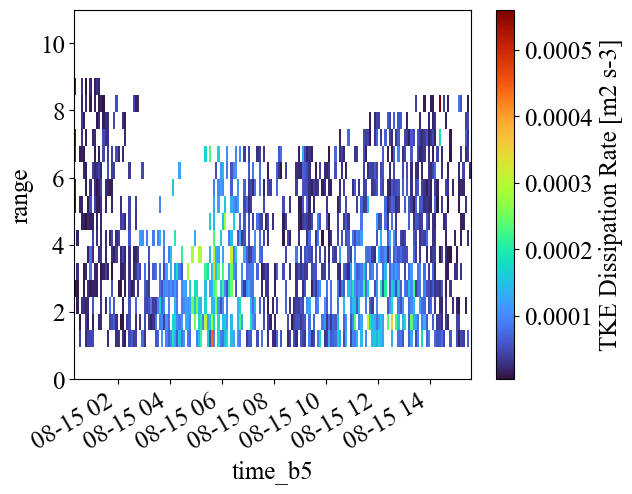

In [28]:
ds_avg["dissipation_rate"].plot(cmap="turbo", ylim=(0, 11))

### 7.5 Noise-Corrected Turbulence Intensity

Now that we've calculated the noise floor for each ping, we can recalculate TI and include subtracting instrument noise using the `turbulence_intensity` function. If we subtract this from the non-noise corrected function, we can see there's a large difference
at slower slow speeds, but the average difference is about 0.008 (0.8%). Notice this will also remove measurements where noise is 
high.

Text(0.5, 1.0, 'TI Difference')

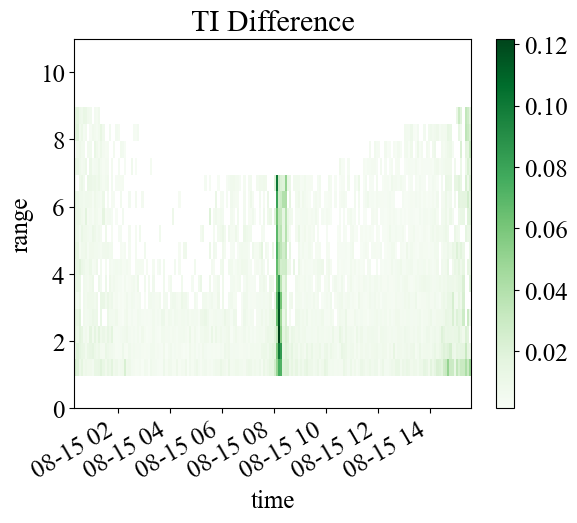

In [29]:
ds_avg["turbulence_intensity"] = avg_tool.turbulence_intensity(ds.velds.U_mag, noise=ds_avg["noise"])

(ds_avg["TI"] - ds_avg["turbulence_intensity"]).plot(cmap="Greens", ylim=(0, 11))
plt.title("TI Difference")

### 7.6 Turbulent Kinetic Energy (TKE) Components

The next parameters we'll find here are the vertical TKE component and the total TKE magnitude. Since we're using the vertical beam on the ADCP, we'll directly measure the vertical TKE component from the along-beam velocity using the `turbulent_kinetic_energy` function. This function is capable of calculating TKE for any along-beam velocity.

We can also use the so-called "beam-variance" equations to estimate the Reynolds stress tensor components (i.e. $\overline{u'^2}$, $\overline{v'^2}$, $\overline{w'^2}$, $\overline{u'v'}$, $\overline{u'w'^2}$, $\overline{v'w'^2}$), which define the stresses acting on an element of water. These equations are built into the functions `stress_tensor_5beam` and `stress_tensor4beam`. Since we're using a 5-beam ADCP, we can calculate the total TKE as well using `total_turbulent_kinetic_energy`, which is a wrapper around the 5-beam variance function.

#### Quick 5-beam ADCP lesson before we dive in:

There are a couple caveats to calculating Reynolds stress tensor components:
  1. Because this instrument only has 5 beams, we can only find 5 of the 6 components (6 unkowns, 5 knowns)
  2. Because the ADCP's instrument (XYZ) axes weren't aligned with the flow during deployment, we don't know what direction these components are aligned to (i.e. the 'u' direction is not necessarily the streamwise direction)
  3. It is possible to rotate the tensor, but we'd need to know all 6 components to do so properly.

That being said, even if we don't know which direction the 3 TKE components ($\overline{u'^2}$, $\overline{v'^2}$, $\overline{w'^2}$) are oriented, we can still combine them and get the total TKE magnitude.

We'll first calculate the vertical TKE component, using the function `turbulent_kinetic_energy`, inputting our raw vertical beam data and the noise floors we calculated above for each ensemble.

In [30]:
# Vertical TKE component (w'w' bar)
ds_avg["wpwp_bar"] = avg_tool.turbulent_kinetic_energy(
    ds["vel_b5"], noise=ds_avg["noise"]
)

Next we can calculate the TKE magnitude using the function `total_turbulent_kinetic_energy`. This method is a wrapper around the `stress_tensor_5beam` function, which calculates the individual Reynolds stress tensor components and takes the same inputs. As an fyi, this function will drop at least one warning every time it's run, primarily the coordinate system warning. This function also requires the input raw data to be in beam coordinates, so we'll create a copy of the raw data and rotate it to 'beam'. If you do not, this function will do so automatically and rotate the original.

In [31]:
ds_beam = dolfyn.rotate2(ds, "beam", inplace=False)
ds_avg["TKE"] = avg_tool.total_turbulent_kinetic_energy(
    ds_beam, noise=ds_avg["noise"], orientation="up", beam_angle=25
)

c:\users\mcve343\mhkit-python\mhkit\dolfyn\adp\turbulence.py:401: UserWarning:     The beam-variance algorithms assume the instrument's (XYZ) coordinate system is aligned with the principal flow directions.
  warnings.warn(


And plotting TKE:

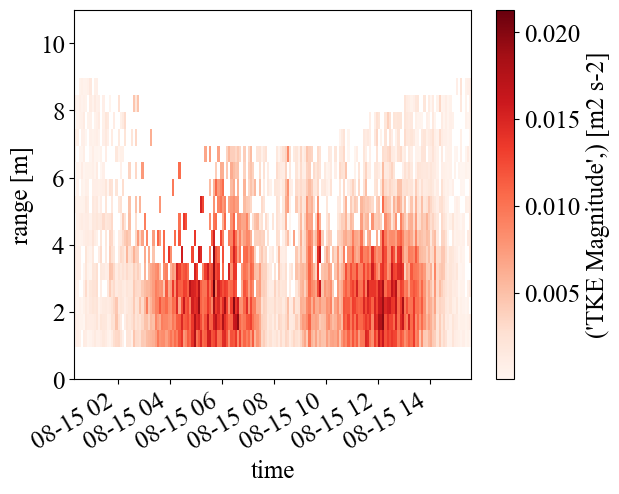

In [32]:
# Remove estimations below 0
ds_avg["TKE"] = ds_avg["TKE"].where(ds_avg["TKE"] > 0)

ds_avg["TKE"].plot(cmap="Reds", ylim=(0, 11))

TKE esimations are generally more complete than those of dissipation rates because they are found directly from the along-beam velocity measurements. Missing TKE estimations exist whenever the noise calculated by the function `doppler_noise_level` is greater than the calculated TKE, as TKE can't be less than zero. Noise levels are affected by the instrument's processor and working frequency, water waves and other sources of "interference", instrument motion, current speed, intricacies in the spectra calculation, the ability to see the noise floor in the spectra, etc.

You may also note that high TI doesn't always correlate with high TKE. TI is the ratio of flow speed standard devation to the mean, which is naturally lower when flow speeds are higher. When flow speeds are higher, they also have greater kinetic energy and thereby greater TKE.

There is one other important thing to note on TKE measurements by ADCPs: the minimum turbulence length scale that the ADCP is capable of measuring increases with range from the instrument. This means the instrument is only capable of measuring the TKE of larger and larger turbulent structures as the beams travel farther and farther from the instrument head. One of the benefits of calculating w'w' from the vertical beam is that it isn't limited by this beam spread issue.

### 7.7 TKE Production

Though it can't be found from this deployment, we'll go over how to estimate TKE Production. There isn't a specific function in MHKiT-DOLfYN for production, but all the necessary variables are. 

If we had aligned the ADCP instrument axes to the flow direction (so "X" would align with the main flow), we could use the following equation to estimate production:

$P = -(\overline{u'w'}\frac{du}{dz} + \overline{v'w'}\frac{dv}{dz} + \overline{w'w'}\frac{dw}{dz})$

To start, we need the functions `reynolds_stress_4beam` or `stress_tensor_5beam` to get the stress tensor components $\overline{u'w'}$ and $\overline{v'w'}$. We also need the vertical TKE component, $\overline{w'w'}$. 

Both of these functions will give comparable results, but it should be noted that `stress_tensor_4beam` assumes the instrument is oriented with 0 degrees pitch and roll, and will throw a warning if they are greater than 5 degrees. The `stress_tensor_5beam` gives more leeway to instrument tilt, but shouldn't be used if pitch and roll angles are greater than 10 degrees.

In [33]:
# Beam-variance equation for 4-beam ADCPs
stress_vec = avg_tool.reynolds_stress_4beam(
    ds_beam, noise=ds_avg["noise"], orientation="up", beam_angle=25
)
upwp_ = stress_vec[1]
vpwp_ = stress_vec[2]
wpwp_ = ds_avg["wpwp_bar"]  # Found from the vertical along-beam velocity (vel_b5) above

# OR #

# Beam-variance equation for 5-beam ADCPs
tke_vec, stress_vec = avg_tool.stress_tensor_5beam(
    ds_beam, noise=ds_avg["noise"], orientation="up", beam_angle=25
)
upwp_ = stress_vec[1]
vpwp_ = stress_vec[2]
wpwp_ = tke_vec[2]

c:\users\mcve343\mhkit-python\mhkit\dolfyn\adp\turbulence.py:401: UserWarning:     The beam-variance algorithms assume the instrument's (XYZ) coordinate system is aligned with the principal flow directions.
  warnings.warn(
c:\users\mcve343\mhkit-python\mhkit\dolfyn\adp\turbulence.py:411: UserWarning:     100.0 % of measurements have a tilt greater than 5 degrees.
  warnings.warn(


The shear components can be found from the aptly named functions `dudz`, `dvdz`, and `dwdz` in ADPBinner. These functions, which are useful alone in their own right, estimate the shear in the velocity vector between respective depth bins. There is always correlation between velocity measurements in adjacent depth bins, based on ADCP operation principles, which is why "estimation" is also used here for shear.

The shear functions operate on the raw velocity vector in the principal reference frame and need to be ensemble-averaged here. This can be done by nesting the `d*dz` function within the ADPBinner's `mean` function. With the ensemble shear known, we can put all the components together to get a production estimation.

In [34]:
# Find and ensemble-average shear
dudz = avg_tool.mean(avg_tool.dudz(ds_streamwise["vel"]).values)
dvdz = avg_tool.mean(avg_tool.dvdz(ds_streamwise["vel"]).values)
dwdz = avg_tool.mean(avg_tool.dwdz(ds_streamwise["vel"]).values)

# Calculate Production
P = -(upwp_ * dudz + vpwp_ * dvdz + wpwp_ * dwdz)

### 7.8 TKE Balance 

We can plot TKE Production and compare it to our dissipation rate calculations to get an understanding of the TKE balance. In a well mixed coastal environment, we expect production and dissipation to be approximately equal. Our production estimates aren't accurate because our stress components aren't aligned with the flow, so if we plot them, we see drastic differences (1x10^-3 $m^2/s^3$ is quite large) profile here.

Text(0.5, 1.0, 'TKE Balance')

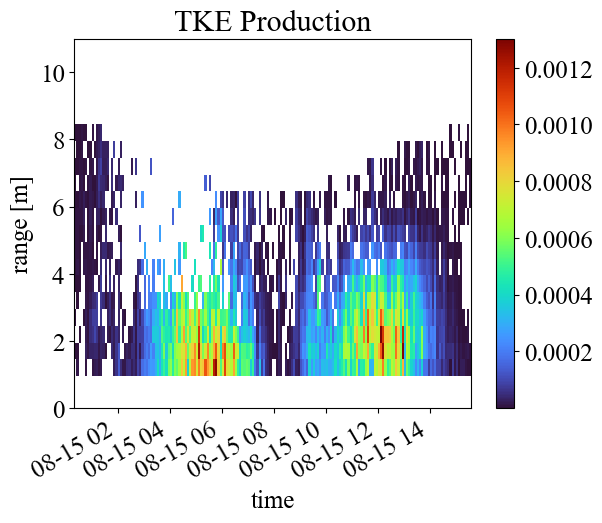

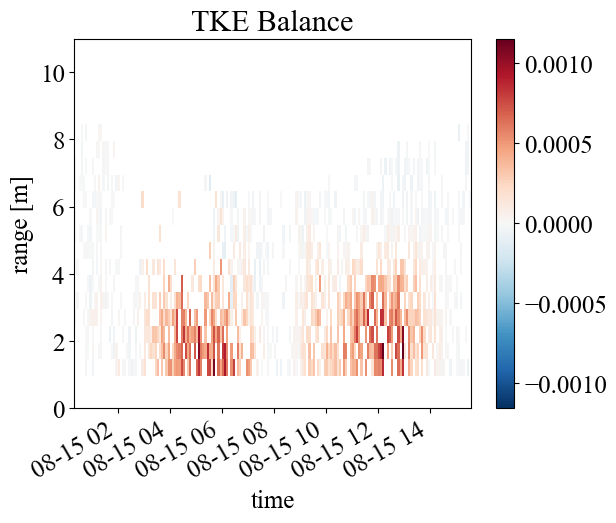

In [35]:
# Remove estimations below 0
P = P.where(P > 0)
P.plot(cmap="turbo", ylim=(0, 11))
plt.title("TKE Production")  # remove bogus title


# Plot difference between production and dissipation
plt.figure()
(P - ds_avg["dissipation_rate"].values).plot(ylim=(0, 11))
plt.title("TKE Balance")